# Life history trade-offs: Antibiotic Resistance and Vaccination

In [428]:
#imports

import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider

The parameter values were taken from Lehtinen 2018 and Colijn 2009

## SISV model modelling antibiotic resistance in response to vaccine rollout

### Model 

In order to model vaccination as a real rollout and not just a mere drop in susceptibles, we will have to create a new model, including a compartement of susceptibles $S$ and vaccinated individuals $V$. Then we have two classes of infecteds, vaccine-type $v$ and non-vaccine-type $nv$ and for each of these classes two categories, namely antibiotic sensitive $s$ and antibiotic resistant $r$. In order to track who was vaccinated and who wasn't we subdivide the $nv$ compartments further into an $nv,S$ for non-vaccine-type coming from the susceptibles and $nv,V$ for non-vaccine-type coming from the vaccinated compartement. For the vaccine-type we don't have to make this subdivision, because the vaccine-type can only infect susceptibles but not vaccinated individuals.

![](SISV.png)

The model gives rise to the following ODE system:

$$
\begin{aligned}
\frac{dS}{dt} &= (\gamma + \tau)(I_s^{nv,S}+I_s^v) - \beta S (I_s^{nv,S}+I_s^v) + c_{\gamma}\gamma(I_r^{nv,S}+I_r^v) - \frac{\beta}{c_{\beta}}S(I_r^{nv,S}+I_r^v) - \nu S\\
\frac{dI_s^{nv,S}}{dt} &= \beta S I_s^{nv,S} - (\gamma + \tau) I_s^{nv,S} - \nu I_s^{nv,S}\\
\frac{dI_r^{nv,S}}{dt} &= \frac{\beta}{c_{\beta}} S I_r^{nv,S} - c_{\gamma}\gamma I_r^{nv,S} - \nu I_r^{nv,S}\\
\frac{dI_s^{nv,V}}{dt} &= \beta V I_s^{nv,V} - (\gamma + \tau) I_s^{nv,V} + \nu I_s^{nv,S}\\
\frac{dI_r^{nv,V}}{dt} &= \frac{\beta}{c_{\beta}} V I_r^{nv,V} - c_{\gamma}\gamma I_r^{nv,V} + \nu I_r^{nv,S}\\
\frac{dI_s^v}{dt} &= \beta S I_s^v - (\gamma + \tau) I_s^v - \nu I_s^v\\
\frac{dI_r^v}{dt} &= \frac{\beta}{c_{\beta}} S I_r^v - c_{\gamma}\gamma I_r^v - \nu I_r^v\\
\frac{dV}{dt} &= \nu S + (\gamma + \tau)I_s^{nv,V} - \beta V I_s^{nv,V} + c_{\gamma}\gamma I_r^{nv,V} - \frac{\beta}{c_{\beta}} V I_r^{nv,V} + \nu (I_s^v + I_r^v)
\end{aligned}
$$

If we want to introduce a rollout of the vaccine after reaching equilibrium, we need to have sensitive and resistant individuals. In order to do this we will enforce coexistence. We saw that the $R_0$ values for the sensitives and the resistants need to be the same as we have derived in the script SIS: $\frac{\beta}{\gamma + \tau} = \frac{\beta}{c_{\gamma}c_{\beta}\gamma}$. We obtain the relationship $R_{0_s} = R_{0_r}$ at equilibrium and in this state we will reach the equilibrium of coexistence. 

we can derive a condition on the antibiotic consumption rate in which case we reach coexistence:
$$
\begin{aligned}
R_{0_s} &= R_{0_r}\\
\frac{\beta}{\gamma + \tau} &= \frac{\beta}{c_{\gamma}c_{\beta}\gamma}\\
\tau &= \gamma (c_{\gamma}c_{\beta} - 1)
\end{aligned}
$$

So in the beginning I let the two vaccinated and susceptible Infected subcompartments evolve in equilibrium. This means I will set the parameters $\tau$ to be as above and $\nu$ to be zero so that we have no vaccinated indivudals. In order not to have too much confounding by the coexistence assumption, I introduce a very small competition in the value of $\Delta = 0.01$ which leads to the strains still coexisting but in the long term after vaccination we see a competitive effect.

In [495]:
#available population to infect
N = 1000

#prior infected susceptible and resistant
IsnvS0, IrnvS0, IsnvV0, IrnvV0, Isv0, Irv0, V0 = 2, 1, 0, 0, 1, 1, 0

#prior susceptible
S0 = N - IsnvS0 - IrnvS0 - IsnvV0 - IrnvV0 - Isv0 - Irv0 - V0

#parameters
beta = 2/N 

#clearance rate
gamma = 1.0

#vaccination rate
nu = 0.05

#interval to plot
t = 350

#terms to be added because of resistance modelling
cg = 1.0
cb = 1.1
tau = gamma * (cb * cg - 1) + 0.01
print(tau)

0.11000000000000008


in order to have a small competition I add a $\Delta = 0.01$ to the $\tau$ set up for coexistence

In [496]:
#PRE: all variables are positive integers
#POST: The SISV model on antibiotic resistance with vaccine rollout

def SISV (t, y, N, beta, gamma, cg, cb, tau, nu):
    # passing the initial vector
    S, IsnvS, IrnvS, IsnvV, IrnvV, Isv, Irv, V = y

    # in the first 50 timesteps we have no vaccination
    if(t<50):
        # in the beginning we have no vaccination so 
        nu = 0

    # susceptibles
    dSdt = (gamma + tau) * (IsnvS + Isv) - beta * S * (IsnvS + Isv) + cg * gamma * (IrnvS + Irv) - beta/cb * S * (IrnvS + Irv) - nu * S

    # non-vaccine-type
    dIsnvSdt = beta * S * IsnvS - (gamma + tau) * IsnvS - nu * IsnvS 
    dIrnvSdt = beta/cb * S * IrnvS - cg * gamma * IrnvS - nu * IrnvS
    dIsnvVdt = beta * V * IsnvV - (gamma + tau) * IsnvV + nu * IsnvS
    dIrnvVdt = beta/cb * V * IrnvV - cg * gamma * IrnvV + nu * IrnvS

    #these values don't change
    dIsvdt = beta * S * Isv - (gamma + tau) * Isv - nu * Isv
    dIrvdt = beta/cb * S * Irv - cg * gamma * Irv - nu * Irv

    # set the vaccinated individuals to be zero until we roll the vaccine out
    dVdt = nu * S + (gamma + tau) * IsnvV - beta * V * IsnvV + cg * gamma * IrnvV - beta/cb * V * IrnvV + nu * (Isv + Isv)

    return dSdt, dIsnvSdt, dIrnvSdt, dIsnvVdt,dIrnvVdt, dIsvdt, dIrvdt, dVdt

### Solving the ODE system

In [497]:
#numerically integrate the ODEs
y0 = S0, IsnvS0, IrnvS0, IsnvV0, IrnvV0, Isv0, Irv0, V0
sol = solve_ivp(SISV, [0,t], y0, rtol=1e-6, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau, nu))

### Plotting the results


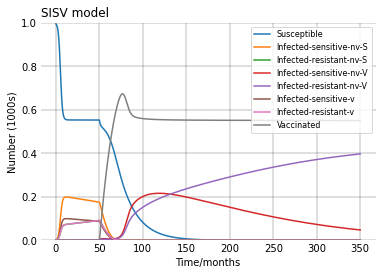

In [498]:
#plot
fig = plt.figure()
ax = fig.add_subplot(111,  axisbelow=True)
curves = ax.plot(sol.t, sol.y.T/1000)
ax.legend(curves, ['Susceptible', 'Infected-sensitive-nv-S', 'Infected-resistant-nv-S', 'Infected-sensitive-nv-V', 'Infected-resistant-nv-V', 'Infected-sensitive-v', 'Infected-resistant-v', 'Vaccinated'], prop={'size': 8})
ax.set_xlabel('Time (months)')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SISV model', loc='left')
plt.show()

This plot describes the trajectories of our SISV model. The y-axis are the number of individuals per compartment counted in 1000s and the x-axis is time measured in months. We plot the trajectories over a timecourse of 350 months. In the first 50 months we have no vaccination, after which we introduce a vaccination campaign at a rate $\nu$ of 5% per month. The other parameters were chosen to reflect the dynamics of *Strepotcoccus Pneumoniae*. The parameter $\tau$ reflects the rate of treatment. This was chosen in an artificial manner to obtain coexistence between the strains. In order to have some slight competition we have a very small $\Delta = 0.01$ from this coexistence criterion described above. We add this value in order to get outcompetition of the sensitive strain by the resistant one in the long term.
 
In the first 50 months we see that the number of susceptibles drops and we have an increase in infections with the sensitive strains have a slight advantage over the resistant types. When we start the vaccination at timepoint 50 we see that we have more sensitive-strain infections than resistant ones. Then what we observe is that the vaccine-type strains drop first and only after some lag do the non-vaccine-type strains pick up and rise. In the beginning the sensitive and resistant strains behave similarly but the sensitive ones take the lead quickly and at $t \sim 110$ months do the resistant types decrease again and we approach an equilibrium where the sensitive strains outcompete the resistant strains.

### Interactive plotting tool

In [499]:
#numerically integrate the ODEs
def interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, nu):
    #defining the susceptibles for the model - will reduce the number of available hosts by introducing more vaccinated hosts
    y0 = S0, IsnvS0, IrnvS0, IsnvV0, IrnvV0, Isv0, Irv0, V0
    #solve the SIS numerically
    sol = solve_ivp(SISV, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau, nu))
    #plot the results
    fig = plt.figure()
    ax = fig.add_subplot(111,  axisbelow=True)
    curves = ax.plot(sol.t, sol.y.T/1000)
    ax.legend(curves, ['Susceptible', 'Infected-susceptible-nv-S', 'Infected-resistant-nv-S', 'Infected-susceptibles-nv-V', 'Infected-resistant-nv-V', 'Infected-susceptibles-v', 'Infected-resistant-v', 'Vaccinated'])
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.5)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title('SISV model', loc='left')
    plt.show()

In [500]:
interact(interactive_plot, y0 = fixed(y0) , t = fixed(t), N = fixed(N), beta = widgets.FloatSlider(min=0.1/N, max=4/N, step=0.1/N, value=beta), gamma = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=gamma), cg = (cg), cb = (cb) , tau = widgets.FloatSlider(min=0.05, max=1, step=0.05, value=tau), nu = widgets.FloatSlider(min=0.01, max=1, step=0.01, value = nu))

interactive(children=(FloatSlider(value=0.002, description='beta', max=0.004, min=0.0001, step=0.0001), FloatS…

<function __main__.interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, nu)>

### Plotting the subcompartments of nv together

In [501]:
sol_df = pd.DataFrame(sol.y)

In [502]:
sol_df

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,995.0,994.986691,994.851661,994.613115,994.364929,994.106701,993.838031,993.558496,993.267658,992.965059,...,1.766566e-03,1.222773e-03,8.986333e-04,7.593523e-04,6.416588e-04,5.445995e-04,4.622218e-04,3.954201e-04,3.399202e-04,3.045853e-04
1,2.0,2.005501,2.061340,2.160099,2.262994,2.370203,2.481905,2.598284,2.719537,2.845866,...,4.460467e-75,-3.304140e-73,1.361647e-71,-7.095162e-71,3.697094e-70,-1.753766e-69,8.319233e-69,-3.308702e-68,1.174739e-67,-1.240500e-67
2,1.0,1.002529,1.028164,1.073369,1.120290,1.168997,1.219556,1.272039,1.326518,1.383071,...,-1.108939e-70,5.905853e-69,-1.741885e-67,6.361636e-67,-2.323371e-66,7.712723e-66,-2.560338e-65,7.102607e-65,-1.754621e-64,1.209501e-64
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.442780e+01,6.054962e+01,5.744960e+01,5.580914e+01,5.420857e+01,5.268703e+01,5.120249e+01,4.982240e+01,4.851649e+01,4.758691e+01
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.802472e+02,3.841731e+02,3.873115e+02,3.889713e+02,3.905927e+02,3.921313e+02,3.936361e+02,3.950307e+02,3.963550e+02,3.972947e+02
5,1.0,1.002750,1.030670,1.080049,1.131497,1.185102,1.240952,1.299142,1.359768,1.422933,...,2.230233e-75,-1.652070e-73,6.808235e-72,-3.547581e-71,1.848547e-70,-8.768832e-70,4.159616e-69,-1.654351e-68,5.873696e-68,-6.202499e-68
6,1.0,1.002529,1.028164,1.073369,1.120290,1.168997,1.219556,1.272039,1.326518,1.383071,...,-1.108939e-70,5.905853e-69,-1.741885e-67,6.361636e-67,-2.323371e-66,7.712723e-66,-2.560338e-65,7.102607e-65,-1.754621e-64,1.209501e-64
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.507936e+02,5.507465e+02,5.507084e+02,5.506893e+02,5.506686e+02,5.506516e+02,5.506314e+02,5.506170e+02,5.505986e+02,5.505886e+02


In [503]:
sensitives = sol_df.loc[1,:].add(sol_df.loc[3,:])
resistant = sol_df.loc[2,:].add(sol_df.loc[4,:])

In [504]:
# copy the dataframe and delete the subcompartments in the new version
added_df = sol_df
added_df = added_df.drop(added_df.index[1:5])
added_df = added_df.append(sensitives, ignore_index=True)
added_df = added_df.append(resistant, ignore_index=True)

added_df

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,995.0,994.986691,994.851661,994.613115,994.364929,994.106701,993.838031,993.558496,993.267658,992.965059,...,1.766566e-03,1.222773e-03,8.986333e-04,7.593523e-04,6.416588e-04,5.445995e-04,4.622218e-04,3.954201e-04,3.399202e-04,3.045853e-04
1,1.0,1.002750,1.030670,1.080049,1.131497,1.185102,1.240952,1.299142,1.359768,1.422933,...,2.230233e-75,-1.652070e-73,6.808235e-72,-3.547581e-71,1.848547e-70,-8.768832e-70,4.159616e-69,-1.654351e-68,5.873696e-68,-6.202499e-68
2,1.0,1.002529,1.028164,1.073369,1.120290,1.168997,1.219556,1.272039,1.326518,1.383071,...,-1.108939e-70,5.905853e-69,-1.741885e-67,6.361636e-67,-2.323371e-66,7.712723e-66,-2.560338e-65,7.102607e-65,-1.754621e-64,1.209501e-64
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.507936e+02,5.507465e+02,5.507084e+02,5.506893e+02,5.506686e+02,5.506516e+02,5.506314e+02,5.506170e+02,5.505986e+02,5.505886e+02
4,2.0,2.005501,2.061340,2.160099,2.262994,2.370203,2.481905,2.598284,2.719537,2.845866,...,6.442780e+01,6.054962e+01,5.744960e+01,5.580914e+01,5.420857e+01,5.268703e+01,5.120249e+01,4.982240e+01,4.851649e+01,4.758691e+01
5,1.0,1.002529,1.028164,1.073369,1.120290,1.168997,1.219556,1.272039,1.326518,1.383071,...,3.802472e+02,3.841731e+02,3.873115e+02,3.889713e+02,3.905927e+02,3.921313e+02,3.936361e+02,3.950307e+02,3.963550e+02,3.972947e+02


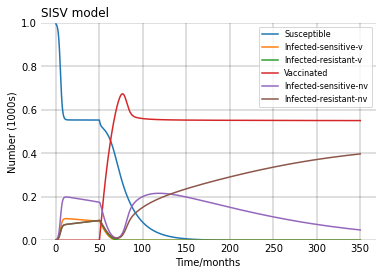

In [505]:
#plot

fig = plt.figure()
ax = fig.add_subplot(111,  axisbelow=True)
curves = ax.plot(sol.t, np.transpose(np.array(added_df/1000)))
ax.legend(curves, ['Susceptible', 'Infected-sensitive-v', 'Infected-resistant-v', 'Vaccinated','Infected-sensitive-nv', 'Infected-resistant-nv'], prop={'size': 8})
ax.set_xlabel('Time (months)')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SISV model', loc='left')
plt.show()